In [1]:
import sys
sys.path.append("/Volumes/pdoubraw-1/repos/ABLTools/python/")
sys.path.append("C:/Users/krydalch/Documents/Repos/ABLtools_python/")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import stochasticTurbulenceTools as stt
import glob, os
import pandas as pd
import functions as f

sys.path.append("C:/Users/krydalch/Documents/Repos/")
from datatools import wfip2
from datatools.remote_sensing import scintec_profiler

In [3]:
plt.rc("font",size=14)

In [4]:
kir_ts = stt.stochasticTurbulence("TurbSim")

In [5]:
#kir_ts.readBTS("/Users/pdoubraw/Downloads/")
kir_ts.readBTS("C:/Users/krydalch/Desktop/TurbSim/MyOutputFiles/LLJ/1440_1450_rand1/")

Opening file C:/Users/krydalch/Desktop/TurbSim/MyOutputFiles/LLJ/1440_1450_rand1/TurbSim.bts...


## Load in sonic and sodar data

In [6]:
df_sonic = pd.read_csv('UTS_1440_1450.txt', sep='\t', header=None)

sodar_path = "/Volumes/pdoubraw-1/repos/jet/data/"
sodar_path = "C:\\Users\\krydalch\\Desktop\\MetMastData\\SODAR\\"

df = wfip2.read_dir(dpath=sodar_path, reader=scintec_profiler, ext='mnd')
df = df.set_index("datetime")
# Remove Faulty Data
df = df.replace("99.99",None)
df = df.replace("999.9",None)

df['wind speed'] = df['wind speed'].astype(float)

time_vs_height = df[["wind speed","height"]].reset_index().set_index(["datetime","height"]).unstack().astype("float")
time_vs_height.index = time_vs_height.index.tz_localize("UTC")
df_sdr = time_vs_height.copy()

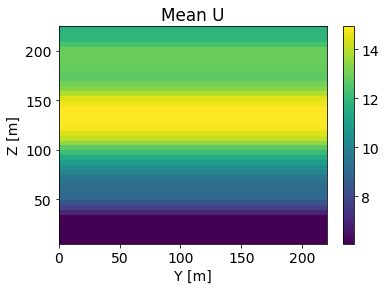

In [7]:
plt.pcolormesh(kir_ts.y, kir_ts.z, np.mean(kir_ts.u,axis=0).T)
plt.title("Mean U")
plt.xlabel("Y [m]")
plt.ylabel("Z [m]")
plt.colorbar()
#plt.savefig("../Trouble.png",bbox_inches="tight",dpi=500)

# Import True Sodar to analyze full profile

In [8]:
year   = 2017 
month  = 2
day    = 17
hour   = 18
minute = int('00')

path_to_csvs   = "/Volumes/pdoubraw/repos/jet/data/TTU 200 m tower data/"
path_to_csvs   = "C:\\Users\\krydalch\\Desktop\\MetMastData\\TTU tall tower\\"
filepaths_dict = f.get_file_paths(path_to_csvs, day=17)

height_feet_dict, height_meters_dict, header_names_dict, unique_heights, unique_heights_all = f.get_file_headers(path_to_csvs)
desired_start = pd.Timestamp(year=year,month=month,day=day,hour=hour,minute=minute)
desired_end   = desired_start + pd.Timedelta('10min')
timestamp_in_filename = desired_start.floor('30min')


nope


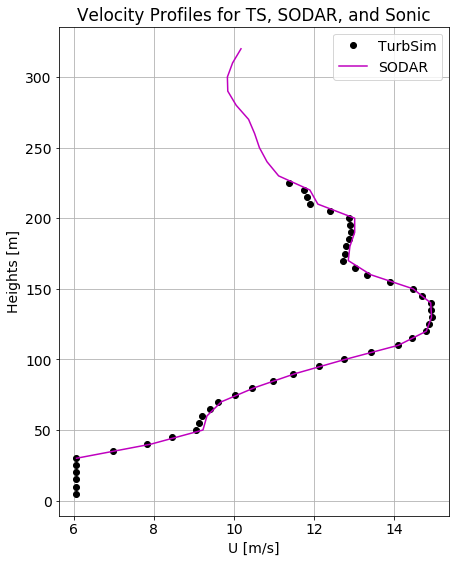

In [20]:
time_of_interest = '2017-02-17 14:40:00+00:00'
fig = plt.figure(figsize=(7,3*3))
half_ind_y = len(kir_ts.y)/2

u_TS = []
hs = []
u_sonic = []

#################### TS ##############################
i = 0
# Find avg U for each height TS
for z in kir_ts.z:
    #print(np.mean(kir_ts.u[:,int(half_ind_y),i]))
    u_TS = np.append(u_TS,np.mean(kir_ts.u[:,int(half_ind_y),i]))
    
    hs = np.append(hs, z)
    i = i + 1

#################### SONIC ##############################
us = range(1,5,3)
heights = [116.4, 158.2]
u_max = 0
for u_h in us:
    u_now_mean = np.mean(df_sonic[u_h])
    u_sonic= np.append(u_sonic,u_now_mean)

    


#################### SODAR ##############################
resamp = df_sdr["wind speed"]
a = resamp.loc[time_of_interest ]

try:
    del u_sonic[200.0]

except:
    print("nope")
# ax = fig.add_subplot(3,1,1) 
# ax.plot(u_TS,kir_ts.z)


#plt.plot(u_sonic,heights,"g--",label = 'Sonic')
plt.plot(u_TS,hs,'ko',label = 'TurbSim')
plt.plot(a.values,a.index,"m",label = 'SODAR')

plt.title('Velocity Profiles for TS, SODAR, and Sonic')
plt.xlabel('U [m/s]')
plt.ylabel('Heights [m]')
#plt.style.use('seaborn-darkgrid')
plt.legend()
plt.grid(True)



fig.savefig("../SODAR_LLJ_profiles1.png",bbox_inches="tight",dpi=500)

In [12]:
df_sonic.head()

,0,1,2,3,4,5,6
0,0.00,13.900721,-0.226858,0.121599,13.390578,-0.383827,0.105268
1,0.05,13.896216,-0.219621,0.150603,13.404489,-0.417997,0.152290
2,0.10,13.914371,-0.237159,0.127056,13.401079,-0.415974,0.114126
3,0.15,13.938699,-0.200345,0.044073,13.394255,-0.399115,0.118177
4,0.20,13.970476,-0.210321,0.071994,13.407195,-0.380446,0.104108


## Find Head of Jet

In [18]:
resamp = df_sdr["wind speed"]
sdr = resamp.loc[time_of_interest ]

try:
    del sdr[200.0]

except:
    print("nope")
    
u_max = 0
for h in sdr.index:
    u_now = sdr.loc[h]
    if u_now > u_max:
        u_max = u_now
        h_max = h

        
print('The LLJ nose {0} and speed are:',h_max,u_max)

The LLJ nose {0} and speed are: 130.0 14.94


Text(0, 0.5, 'Z [m]')

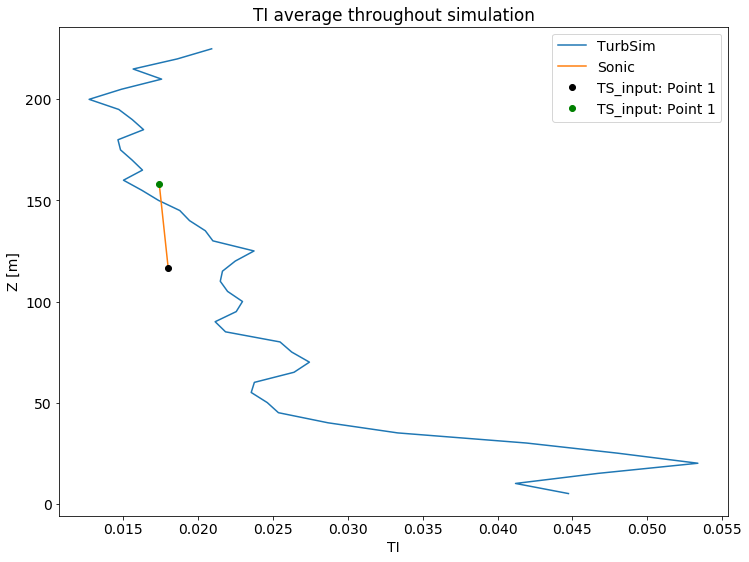

In [14]:

u ={}
v = {}
w = {}

ti =[]

#kir_ts
us = range(1,5,3)
heights = [116.4, 158.2]
time = df_sonic.loc[:,0]
i = 0
for u_h in us:
    u[heights[i]] = df_sonic[u_h]
    v[heights[i]] = df_sonic[u_h+1]
    w[heights[i]] = df_sonic[u_h+2]
    
    uu = np.sqrt((df_sonic[u_h] - df_sonic[u_h].mean())**2)
    
    ti_s = (uu/ df_sonic[u_h].mean()).mean()

    ti = np.append(ti,ti_s)
    i = i +1

TI_turb = kir_ts.TI()
Ti_hub = TI_turb[kir_ts.jHub, :]

fig = plt.figure(figsize=(12,9))

plt.plot(Ti_hub,kir_ts.z,label = 'TurbSim')
plt.plot(ti,heights,label= 'Sonic')
plt.plot(ti[0],heights[0],'ko',label='TS_input: Point 1')
plt.plot(ti[1],heights[1],'go',label='TS_input: Point 1')
plt.legend()
plt.title("TI average throughout simulation")
plt.xlabel("TI")
plt.ylabel("Z [m]")
#fig.savefig("../TurbSim_TI_1440_1450_.png",bbox_inches="tight",dpi=500)

Text(0, 0.5, 'Z [m]')

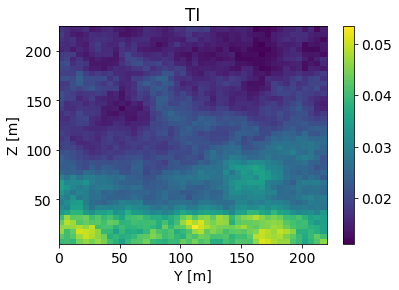

In [15]:
plt.pcolormesh(kir_ts.y, kir_ts.z, kir_ts.TI().T)
plt.colorbar()
plt.title("TI")
plt.xlabel("Y [m]")
plt.ylabel("Z [m]")

In [16]:
kir_ts.z

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
       115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170., 175., 180., 185., 190., 195., 200., 205., 210., 215., 220.,
       225.])

In [17]:
kir_ts.jHub
kir_ts.y[20]
kir_ts.kHub
kir_ts.z[kir_ts.kHub]

115.0

In [18]:
u[height_sonic].mean()

NameError: name 'height_sonic' is not defined

In [19]:
v[height_sonic].mean()

NameError: name 'height_sonic' is not defined

In [20]:
w[height_sonic].mean()

NameError: name 'height_sonic' is not defined

In [21]:
kir_ts.jHub

22

In [24]:
kir_ts.jHub

22

ValueError: operands could not be broadcast together with shapes (12001,) (12000,) 

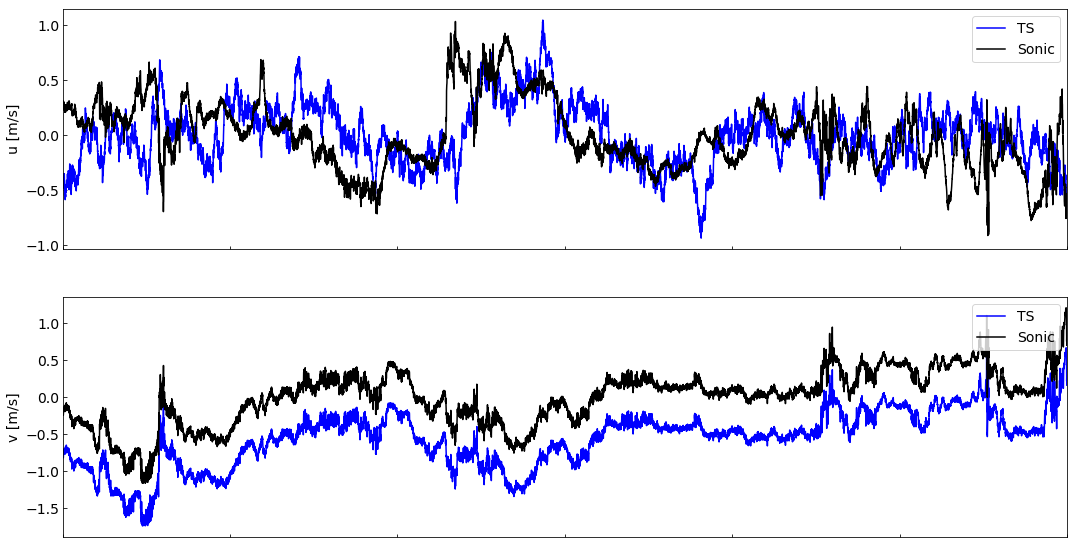

In [16]:

height_sonic = 116.4



u ={}
v = {}
w = {}
#kir_ts
us = range(1,6,3)
heights = [116.4, 158.2]
time = df_sonic.loc[:,0]
i = 0
for u_h in us:
    u[heights[i]] = df_sonic[u_h]
    v[heights[i]] = df_sonic[u_h+1]
    w[heights[i]] = df_sonic[u_h+2]
    i = i +1



times = np.arange(0,kir_ts.nSeconds,kir_ts.dT)

fig = plt.figure(figsize=(18,15))
ax  = {}


# for iax,component in enumerate(['u','v','w']):
########  U ###############
component = 'u'
iax = 1
vel_component = getattr(kir_ts,component)

ax = fig.add_subplot(3,1,iax)    
ax.plot(times, vel_component[:,0, kir_ts.kHub] -np.mean(vel_component[:,kir_ts.jHub, kir_ts.kHub]), 
             '-b', label='TS')
ax.plot(time,u[height_sonic]- np.mean(u[height_sonic]), 
             '-k', label='Sonic')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')   
ax.set_ylabel("{0} [m/s]".format(component))
if iax<2:
    plt.setp(ax.get_xticklabels(), visible=False)
else:
    ax.set_xlabel("time [s]")
ax.set_xlim([0,kir_ts.nSeconds])
plt.legend(loc=1)

########  V ###############
component = 'v'
iax = 2
vel_component = getattr(kir_ts,component)

ax = fig.add_subplot(3,1,iax)    
ax.plot(times, vel_component[:,kir_ts.jHub, kir_ts.kHub], 
             '-b', label='TS')
ax.plot(time,v[height_sonic], 
             '-k', label='Sonic')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')   
ax.set_ylabel("{0} [m/s]".format(component))
if iax<=2:
    plt.setp(ax.get_xticklabels(), visible=False)
else:
    ax.set_xlabel("time [s]")
ax.set_xlim([0,kir_ts.nSeconds])
plt.legend(loc=1)
diff = v[height_sonic]-vel_component[:,kir_ts.jHub, kir_ts.kHub] 
print(diff)


########  W ###############
component = 'w'
iax = 3
vel_component = getattr(kir_ts,component)

ax = fig.add_subplot(3,1,iax)    
ax.plot(times, vel_component[:,kir_ts.jHub, kir_ts.kHub], 
             '-b', label='TS')
ax.plot(time,w[height_sonic], 
             '-k', label='Sonic')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')   
ax.set_ylabel("{0} [m/s]".format(component))
if iax<2:
    plt.setp(ax.get_xticklabels(), visible=False)
else:
    ax.set_xlabel("time [s]")
ax.set_xlim([0,kir_ts.nSeconds])
plt.legend(loc=1)
#fig.savefig("../Warning.png",bbox_inches="tight",dpi=500)